In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import time
import functools
from collections import Counter
#from nxviz import MatrixPlot
from datetime import datetime 
import matplotlib.dates as mdates
import pdb
import matplotlib.ticker as mticker
import pickle
from NetDistr import NetDistr
import seaborn as sb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
from matplotlib import rc
from tqdm import tqdm
import sys
import os
from PlotNet2 import PlotNet
import string

In [3]:
year = '2015'
handel = 2
num_stations = 128
dt_start = '2015-03-17 4:00:00'
dt_end = '2015-03-17 12:00:00'
ulf_fname = 'networks_data/ulf_spd_2015.csv'
indices_fname = 'networks_data/indices_spd_2015.csv'
net_labs = ['dir_net_t1', 'undir_net_inphase', 'undir_net_antiphase']
handel = 'test'
pn = PlotNet(net_labs, ulf_fname, num_stations, dt_start, dt_end, False)
pn_surr = PlotNet(net_labs, ulf_fname, num_stations, dt_start, dt_end, True)
# num_conn = pn.combined_nets_conn(save_analysis_files=False)

In [ ]:
# year = '2015'
# num_stations = 128
# dt_start ='2015-03-17 19:30:00'
# dt_end='2015-03-18 03:30:00'
# ulf_fname = 'networks_data/spd_ulf_min_smr.csv'
# indices_fname = 'networks_data/indices_spd_2015.csv'
# net_labs = ['dir_net_t1', 'dir_net_tn', 'undir_net_inphase', 'undir_net_antiphase']
# # for saving plots
# # handel = 'smr_min'
# pn = PlotNet(net_labs, ulf_fname, num_stations, dt_start, dt_end)
# num_conn = pn.combined_nets_conn(save_analysis_files=True)

In [ ]:
# year = 2013
# num_stations = 122
# dt_start = '2013-03-17 4:00:00'
# dt_end = '2013-03-17 12:00:00'
# ulf_fname = 'networks_data/17march2013_4am.csv'
# indices_fname = 'networks_data/170313_indices.csv'
# pn = PlotNet(net_labs, ulf_fname, num_stations, dt_start, dt_end)
# num_conn = pn.combined_nets_conn(save_analysis_files=False)

In [ ]:
# year = 2012
# num_stations = 133
# dt_start = '2012-01-21 20:00:00'
# dt_end = '2012-01-22 16:00:00'
# ulf_fname = 'networks_data/2012-01-21_22-ulf.csv'
# indices_fname = 'networks_data/2012-01-21_22_indices.csv'
# pn = PlotNet(net_labs, ulf_fname, num_stations, dt_start, dt_end)
# num_conn = pn.combined_nets_conn(save_analysis_files=False)

In [185]:
def label_funct(comp:str, ratio:str):
    if ratio == 'ratio':
        lab_arr = [f'$C_{{{comp}}}/G_{{{comp}}}$',
                   f'$N_{{{comp}}}/G_{{{comp}}}$',f'$L_{{{comp}}}/S_{{{comp}}}$']
    elif ratio == 'ratio_rev':
            lab_arr = [f'$G_{{{comp}}}/C_{{{comp}}}$',
                   f'$G_{{{comp}}}/N_{{{comp}}}$',f'$S_{{{comp}}}/L_{{{comp}}}$']
    elif ratio =='top':
        lab_arr = [f'$C_{{{comp}}}$',f'$N_{{{comp}}}$',f'$L_{{{comp}}}$']
    elif ratio == 'bottom':
            lab_arr = [f'$G_{{{comp}}}$', f'$S_{{{comp}}}$']
    return lab_arr

In [ ]:
def plot_edge_num_ts1(num_conn:dict, indices_fname:str):
    plt.rcParams.update({'font.size': 15})
    num_plots = 5
    fig, ax = plt.subplots(num_plots, figsize=(15, 10))
    fig.suptitle('spd')
    indices = pd.read_csv(indices_fname)
    index_date = indices['Date_UTC']
    sme = indices['SME']
    axsmer = pd.to_datetime(index_date)
    datemin = datetime.strptime(pn.dt_start, '%Y-%m-%d %H:%M:%S')
    datemax = datetime.strptime(pn.dt_end, '%Y-%m-%d %H:%M:%S')
    f1 = ax[0]
    f1.plot(axsmer,sme, color='black', label = 'SME')
    f1.set_ylabel('SME (nT)')
    f1.grid()
#   turn off labels for x axis while preserving ticks
    f1.set_xticklabels([])                           
    f1.set_xlim(datemin,datemax)
    formatter = mdates.DateFormatter("%H:%M")
    f1.xaxis.set_major_formatter(formatter)
    f1.legend()
    f1.set_xlim(datemin,datemax)
    ax2 = f1.twinx()

    # code for plotting SMR sections for entire SMR yearly dataset
    indices['Date_UTC'] = pd.to_datetime(indices['Date_UTC']) 
    for i in ['SMR00','SMR06','SMR12','SMR18' ]:
        x = axsmer[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)]
        y = indices[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)][i]
        ax2.plot(x , y, label= i)
    ax2.xaxis.set_major_formatter(formatter)
    ax2.legend(loc='upper center',ncol=4, bbox_to_anchor=[0.5, 1.4])
    ax2.set_ylabel('SMR (nT)')
    ax2.grid()
    ax2.set_xlim(datemin,datemax)
    ax2.set_xticklabels([])

    dyn_pressure = indices['PDYN']
    # GSM field values
    bz, bx, by = indices['GSM_Bz'], indices['GSM_Bx'], indices['GSM_By']
    f2 = ax[1]
    f3 = ax[2]
    for j in [0,1,2,3]:
        y_vals = [bx, by, bz, dyn_pressure]
        y_labs = ['GSM_Bx','GSM_By','GSM_Bz','Dynamic pressure']
        c = ['red','black','green','orange']
        if j == 3:
            f3.set_ylabel('nPa')
            # get rid of peaks
            y = np.where( y_vals[j] == np.max(y_vals[j]) , np.nan , y_vals[j])
            f3.plot(axsmer, y, label= y_labs[j], color = 'green')
            f = f3
        else:
            y = np.where( y_vals[j] == np.max(y_vals[j]) , np.nan , y_vals[j])
            f2.plot(axsmer, y, label=y_labs[j], color = c[j])
            f = f2

        f.xaxis.set_major_formatter(formatter)
        f.set_xlim(datemin,datemax)
        f.legend(loc='upper center',ncol=3, bbox_to_anchor=[0.5, 1.4])
        f.grid()
        ax[2].legend(bbox_to_anchor=[0.25, 1.4])
        ax3 = ax[2].twinx()
        for k in [0,1]:
            pc_power, power_times = pn.ulf_power(k)
#             print(type(pc_power), len(pc_power['mean_pc_power']))
#             print(len(power_times))
            ax3.plot(power_times, pc_power['mean_pc_power'], label= f'pc{k+2} mean power')
            ax3.xaxis.set_major_formatter(formatter)
        ax3.legend(loc='upper center', ncol=2, bbox_to_anchor=[0.5, 1.4])
        ax3.set_xlim(datemin,datemax)
        ax3.set_ylabel('log(nT)^2')
        f.set_xticklabels([])
        f2.set_ylabel('nT')
        f2.minorticks_on()
        f2.set_xlim(datemin,datemax)
        f2.set_xticklabels([])

    for band in [0,1]:
        plot_num = 3+band
        ylims = dict()
        ylims[band]=[]
        plt.text(0.1, 0.8,f'all_networks_pc{band+2}',transform=ax[plot_num].transAxes, bbox = dict(facecolor = 'white', alpha = 0.5))
        ax[plot_num].grid(visible=True)        
        for comp in ['n','e','z']:
            vals = num_conn[band][comp]
            ylims[band].append(max(vals['total']))
            t = pd.to_datetime(vals.index)
            ax[plot_num].plot(t ,vals['total'].values, label=f'{comp}')
            ax[plot_num].legend(loc='upper right')
            ax[plot_num].xaxis.set_major_formatter(formatter)
            ax[plot_num].set_xlim(datemin,datemax)
        ax[plot_num].set_ylabel('# conn.')
    ax[3].axes.get_xaxis().set_visible(False)
#     plt.savefig(f'plots/{year}_nets/combined_nets_all_comps_{year}_{handel}.png', facecolor='w')
    plt.show()

In [ ]:
plot_edge_num_ts1(num_conn, indices_fname)

In [186]:
def plot_edge_num_ts2(num_conn:dict, indices_fname:str):
    plt.rcParams.update({'font.size': 15})
    num_plots = 7
    fig, ax = plt.subplots(num_plots, figsize=(15, 10))
    fig.suptitle('spd')
    indices = pd.read_csv(indices_fname)
    index_date = indices['Date_UTC']
    sme = indices['SME']
    axsmer = pd.to_datetime(index_date)
    datemin = datetime.strptime(pn.dt_start, '%Y-%m-%d %H:%M:%S')
    datemax = datetime.strptime(pn.dt_end, '%Y-%m-%d %H:%M:%S')
    f1 = ax[0]
    f1.plot(axsmer,sme, color='black', label = 'SME')
    f1.set_ylabel('SME (nT)')
    f1.grid()
#   turn off labels for x axis while preserving ticks
    f1.set_xticklabels([])                           
    f1.set_xlim(datemin,datemax)
    formatter = mdates.DateFormatter("%H:%M")
    f1.xaxis.set_major_formatter(formatter)
    f1.legend()
    f1.set_xlim(datemin,datemax)
    ax2 = f1.twinx()

    # code for plotting SMR sections for entire SMR yearly dataset
    indices['Date_UTC'] = pd.to_datetime(indices['Date_UTC']) 
    for i in ['SMR00','SMR06','SMR12','SMR18' ]:
        x = axsmer[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)]
        y = indices[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)][i]
        ax2.plot(x , y, label= i)
    ax2.xaxis.set_major_formatter(formatter)
    ax2.legend(loc='upper center',ncol=4, bbox_to_anchor=[0.5, 1.5])
    ax2.set_ylabel('SMR (nT)')
    ax2.grid()
    ax2.set_xlim(datemin,datemax)
    ax2.set_xticklabels([])
    step_arr=[0,3]
    for band in [0,1]:
        for comp_ind, comp in enumerate(['n','e','z']):
            plot_num = step_arr[band] + comp_ind+1
            print(f'plot_num is {plot_num}', band, comp)
            plt.text(0, 0.6,f'pc{band+2}, {comp}',transform=ax[plot_num].transAxes, bbox = dict(facecolor = 'white', alpha = 0.2))
            for net_label in net_labs:
                vals = num_conn[band][comp][net_label]
                t = pd.to_datetime(vals.index)
                ax[plot_num].plot(t ,vals['total'].values, label=f'{net_label}')
                ax[plot_num].set_xlim(datemin,datemax)
            ax[plot_num].grid()
            ax[plot_num].legend(loc='upper center',ncol=4, bbox_to_anchor=[0.5, 1.4])
            ax[plot_num].set_ylabel('# conn.')
            if plot_num<6:
                ax[plot_num].set_xticklabels([])

        ax[6].xaxis.set_major_formatter(formatter)
        ax[6].set_xlabel('time hr:min')
        ax[1].set_xticklabels([])
        plt.savefig(f'plots/{year}_nets/all_networks_all_comps_{handel}.png', facecolor='w')
    plt.show()

In [ ]:
num_conn2 = pn.all_nets_conn()

In [ ]:
plot_edge_num_ts2(num_conn2, indices_fname)

In [187]:
def plot_short_long_ts(indices_fname:str, num_conn:dict, band:int, comp:str):
    plt.rcParams.update({'font.size': 15})
    num_plots = 1 + len(net_labs)
    fig, ax = plt.subplots(num_plots, figsize=(12, 8))
    fig.suptitle(f'Pc{band+2}, comp. {comp}')
    indices = pd.read_csv(indices_fname)
    index_date = indices['Date_UTC']
    sme = indices['SME']
    axsmer = pd.to_datetime(index_date)
    datemin = datetime.strptime(dt_start, '%Y-%m-%d %H:%M:%S')
    datemax = datetime.strptime(dt_end, '%Y-%m-%d %H:%M:%S')
    f1 = ax[0]
    f1.plot(axsmer,sme, color='black', label = 'SME')
    f1.set_ylabel('SME (nT)')
    f1.grid()
#   turn off labels for x axis while preserving ticks
    f1.set_xticklabels([])                           
    f1.set_xlim(datemin,datemax)
    formatter = mdates.DateFormatter("%H:%M")
    f1.xaxis.set_major_formatter(formatter)
    f1.legend()
    f1.set_xlim(datemin,datemax)
    ax2 = f1.twinx()

    # code for plotting SMR sections for entire SMR yearly dataset
    indices['Date_UTC'] = pd.to_datetime(indices['Date_UTC']) 
    for i in ['SMR00','SMR06','SMR12','SMR18' ]:
        x = axsmer[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)]
        y = indices[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)][i]
        ax2.plot(x , y, label= i)
    ax2.xaxis.set_major_formatter(formatter)
    # ax2.legend(loc=10)
    ax2.set_ylabel('SMR (nT)')
    ax2.grid()
    ax2.set_xlim(datemin,datemax)
    ax2.set_xticklabels([])

    for ind, val in enumerate(net_labs):
        plot_num = ind+1
        plt.text(0.5, 1,f'{val}', ha='center', va='center', transform=ax[plot_num].transAxes, bbox = dict(facecolor = 'white', alpha = 0.5))
        short_df = num_conn[val]['short']
        long_df = num_conn[val]['long']
        t = pd.to_datetime(short_df.index)
        ax[plot_num].plot(t ,short_df['short'].values, color= 'blue', label = 'short/long', lw=3)
#         ax[plot_num].plot(t ,long_df['long'].values, color= 'red', label = 'long', linestyle='--')
        ax[plot_num].legend(loc='upper left', ncol=2, bbox_to_anchor=[0, 1.3] )
        ax[plot_num].xaxis.set_major_formatter(formatter)
        ax[plot_num].set_xlim(datemin,datemax)
#         ax[plot_num].set_ylabel('# conn.')
        ax[plot_num].grid()

        if plot_num<len(net_labs):
            ax[plot_num].set_xticklabels([])
        plt.savefig(f'plots/{year}_nets/comp_{comp}/long_short_all_nets_{comp}_pc{band+2}_{handel}', facecolor='w')
    

In [4]:
# need to write the code in such a way that plotting parameters are before plotting
net_param_labels = ['ew_div_we', 'ns_div_sn', 'conj_div_north_south', 'north_south_div_north', 'long_div_short','long-mlt_div_short-mlt']
net_dict = {}
for net in net_labs:
    net_dict[net] = {}
    if net == 'dir_net_t1':
        for net_param in net_param_labels:
            net_dict[net][net_param] = pn.single_net_all_comp_and_bands_all_net_params(net, net_param)
            print(net, net_param)
    else:
        for net_param in net_param_labels[2:]:
            net_dict[net][net_param] = pn.single_net_all_comp_and_bands_all_net_params(net, net_param)
            print(net, net_param)

dir_net_t1 ew_div_we
dir_net_t1 ns_div_sn
dir_net_t1 conj_div_north_south
dir_net_t1 north_south_div_north


100%|██████████| 44916/44916 [00:00<00:00, 333630.31it/s]


dir_net_t1 long_div_short


100%|██████████| 44916/44916 [00:01<00:00, 39006.96it/s]


dir_net_t1 long-mlt_div_short-mlt
undir_net_inphase conj_div_north_south
undir_net_inphase north_south_div_north


100%|██████████| 191068/191068 [00:00<00:00, 383241.05it/s]


undir_net_inphase long_div_short


100%|██████████| 191068/191068 [00:04<00:00, 40606.19it/s]


undir_net_inphase long-mlt_div_short-mlt
undir_net_antiphase conj_div_north_south
undir_net_antiphase north_south_div_north


100%|██████████| 176272/176272 [00:00<00:00, 401353.42it/s]


undir_net_antiphase long_div_short


100%|██████████| 176272/176272 [00:04<00:00, 39771.90it/s]


undir_net_antiphase long-mlt_div_short-mlt


In [5]:
# for total connections for each network
all_con_dict = pn.all_nets_conn()
all_surr_con_dict = pn_surr.all_nets_conn()

completed 0, n, dir_net_t1
completed 0, n, undir_net_inphase
completed 0, n, undir_net_antiphase
completed 0, e, dir_net_t1
completed 0, e, undir_net_inphase
completed 0, e, undir_net_antiphase
completed 0, z, dir_net_t1
completed 0, z, undir_net_inphase
completed 0, z, undir_net_antiphase
completed 1, n, dir_net_t1
completed 1, n, undir_net_inphase
completed 1, n, undir_net_antiphase
completed 1, e, dir_net_t1
completed 1, e, undir_net_inphase
completed 1, e, undir_net_antiphase
completed 1, z, dir_net_t1
completed 1, z, undir_net_inphase
completed 1, z, undir_net_antiphase
completed 0, n, dir_net_t1
completed 0, n, undir_net_inphase
completed 0, n, undir_net_antiphase
completed 0, e, dir_net_t1
completed 0, e, undir_net_inphase
completed 0, e, undir_net_antiphase
completed 0, z, dir_net_t1
completed 0, z, undir_net_inphase
completed 0, z, undir_net_antiphase
completed 1, n, dir_net_t1
completed 1, n, undir_net_inphase
completed 1, n, undir_net_antiphase
completed 1, e, dir_net_t1
com

In [210]:
def plot_edge_num_all_net_params(net_label:str, net_dict:dict, net_param_labels:str, indices_fname:str):
    plt.rcParams.update({'font.size': 15})
    num_plots = 4 + len(net_param_labels) + 2
    fig, ax = plt.subplots(num_plots, figsize=(20, 15))
    fig.suptitle(f'spd, Pc2, {net_label}')
    indices = pd.read_csv(indices_fname)
    index_date = indices['Date_UTC']
    axsmer = pd.to_datetime(index_date)
    datemin = datetime.strptime(pn.dt_start, '%Y-%m-%d %H:%M:%S')
    datemax = datetime.strptime(pn.dt_end, '%Y-%m-%d %H:%M:%S')
    formatter = mdates.DateFormatter("%H:%M")

    for ind, lab in enumerate(['GSM_Bz','GSM_By','PDYN']):
        c = ['red','blue','black','green']
        if ind == 2:
            ax2 = ax[0].twinx()
            ax2.set_ylabel('nPa')
            # get rid of peaks
            y = np.where( indices[lab] == np.max(indices[lab]) , np.nan , indices[lab])
            ax2.plot(axsmer, y, label=lab, color = c[ind])
            ax2.set_xlim(datemin,datemax)
        else:
            y = np.where( indices[lab] == np.max(indices[lab]) , np.nan , indices[lab])
            ax[0].plot(axsmer, y, label=lab, color = c[ind])

    ax[0].xaxis.set_major_formatter(formatter)
    ax[0].set_ylabel('nT')
    ax[0].set_xlim(datemin,datemax)
    h1, l1 = ax2.get_legend_handles_labels()
    h2, l2 = ax[0].get_legend_handles_labels()
    ax2.legend(h1+h2, l1+l2,bbox_to_anchor=[0.47, 1.15],ncol=4,loc='upper center')
    ax[0].grid()
    ax[0].set_xticklabels([])
    
#     code for plotting SMR sections for entire SMR yearly dataset
    sme = indices['SME']
    ax[1].plot(axsmer,sme, color='black', label = 'SME')
    ax[1].set_ylabel('SME (nT)')
    ax[1].grid()
#   turn off labels for x axis while preserving ticks
    ax[1].set_xticklabels([])                           
    ax[1].set_xlim(datemin,datemax)
    ax[1].xaxis.set_major_formatter(formatter)
    ax[1].set_xlim(datemin,datemax)
    ax3 = ax[1].twinx()
    indices['Date_UTC'] = pd.to_datetime(indices['Date_UTC']) 
    for i in ['SMR00','SMR06','SMR12','SMR18' ]:
        x = axsmer[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)]
        y = indices[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)][i]
        ax3.plot(x , y, label= i)
    ax3.xaxis.set_major_formatter(formatter)
    ax[1].legend(bbox_to_anchor=[0.1,1.1])
    ax3.legend(bbox_to_anchor=[0.7, 1.1],ncol=4,loc='upper center')
    ax3.set_ylabel('SMR (nT)')
    ax3.grid()
    ax3.set_xlim(datemin,datemax)
    ax3.set_xticklabels([])
  
    
    c = ['r','b','g']
    ls = ['-','--',':']
    for c_ind, comp in enumerate(['n','e','z']):
        net_df = all_con_dict[0][comp][net_label]
        num_stations = pn.n
        max_conn = int(num_stations*(num_stations-1)/2)
        vals = net_df.values/max_conn
        t = pd.to_datetime(net_df.index)
        ax[2].plot(t, vals, color=c[c_ind], ls = ls[c_ind], label = f'$\Theta_{{{comp}}}$')
        ax[2].set_xlim(datemin,datemax)
        ax[2].grid(b=True, which='minor', linestyle='--')
        ax[2].set_yscale('log')
        ax[2].set_ylabel('norm. con.')
        ax[2].minorticks_on()
    ax[2].legend(loc='lower left', ncol=1)
    ax4 = ax[2].twinx()
    pc_power, power_times = pn.ulf_power(0)
    ax4.plot(power_times, pc_power['mean_pc_power'], color = 'black',label= f'pc{2} mean power')
    ax4.xaxis.set_major_formatter(formatter)
    ax4.set_xlim(datemin,datemax)
    ax4.set_ylabel('log(nT)^2')
    ax4.set_xticklabels([])
    ax4.legend(bbox_to_anchor=[0.8, 0.45])
    

    for c_ind, comp in enumerate(['n','e','z']):
        net_df = all_con_dict[0][comp][net_label]
        net_surr_df = all_surr_con_dict[0][comp][net_label]
        surr_ratio = []
        for i in net_df.index:
            if i not in net_surr_df.index:
                surr_ratio.append(0)
            else:
                v1 = net_df.loc[str(i)]['total']
                v2 = net_surr_df.loc[str(i)]['total']
                surr_ratio.append(v2/v1)
                
        plt.text(0, 0.9,f'surrogate',transform=ax[3].transAxes, bbox = dict(facecolor = 'white', alpha = 0.5))
        t1 = pd.to_datetime(net_df.index)
        ax[3].plot(t1, surr_ratio, color=c[c_ind], ls = ls[c_ind], label = f' $\phi_{{{comp}}}$')
        ax[3].set_xlim(datemin,datemax)
    ax[3].grid(b=True, which='minor', linestyle='--')
    ax[3].legend(loc='upper center',ncol=1, bbox_to_anchor=[1.05, 1])
    ax[3].minorticks_on()
    ax[3].set_xticklabels([]) 
    ax[3].set_ylim(0,1) 


#     code for plotting networks
    step = [0,3]
    for ind0, quant in enumerate(['top','bottom']):
        if quant == 'bottom':
            net_param_labels = net_param_labels[1:]
        for ind, net_param in enumerate(net_param_labels):
            lab = net_param.split('_div_')
            if quant =='top':
                lab = lab[0]
            else:
                lab = lab[1]
            plot_num = ind + 4 + step[ind0]
#             changing plot order
            if plot_num == 7:
                plot_num = 6
            elif plot_num ==6:
                plot_num =7
#                 -----------
            plt.text(0, 0.9,f'{lab}',transform=ax[plot_num].transAxes, bbox = dict(facecolor = 'white', alpha = 0.2))
            for c_ind, comp in enumerate(['n','e','z']):
                lab_arr = label_funct(comp, quant)
                net_val = net_dict[net_label][net_param][comp][quant]
                t = pd.to_datetime(net_dict[net_label][net_param][comp][quant].index)
                ax[plot_num].plot(t ,net_val, color=c[c_ind], ls = ls[c_ind], label = f' {lab_arr[ind]}')
            ax[plot_num].set_ylabel('# conn.')
            ax[plot_num].set_xlim(datemin,datemax)
            ax[plot_num].grid()
            ax[plot_num].legend(loc='upper center',ncol=1, bbox_to_anchor=[1.05, 1])
            ax[plot_num].set_yscale('log')        
            if plot_num<num_plots-1:
                ax[plot_num].set_xticklabels([])
            else:
                ax[plot_num].xaxis.set_major_formatter(formatter)
    for n in range(num_plots):
        ax[n].text(-0.07, 0.8, string.ascii_lowercase[n], transform=ax[n].transAxes, 
                size=16, weight='bold')
    
    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.savefig(f'plots/{year}_nets/{net_label}_all_comps_all_net_params.png', facecolor='w')
#     plt.show()

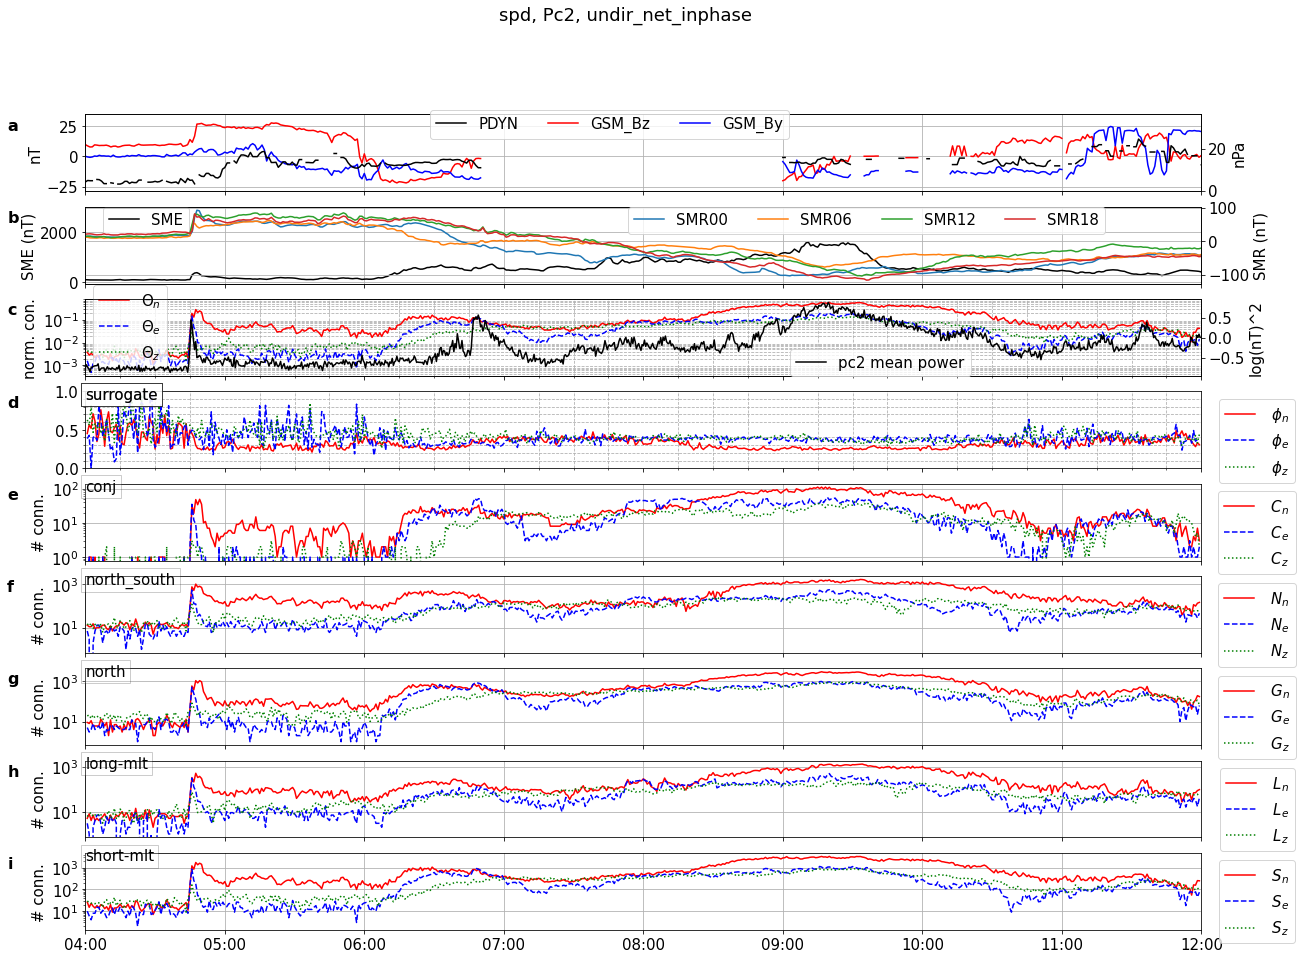

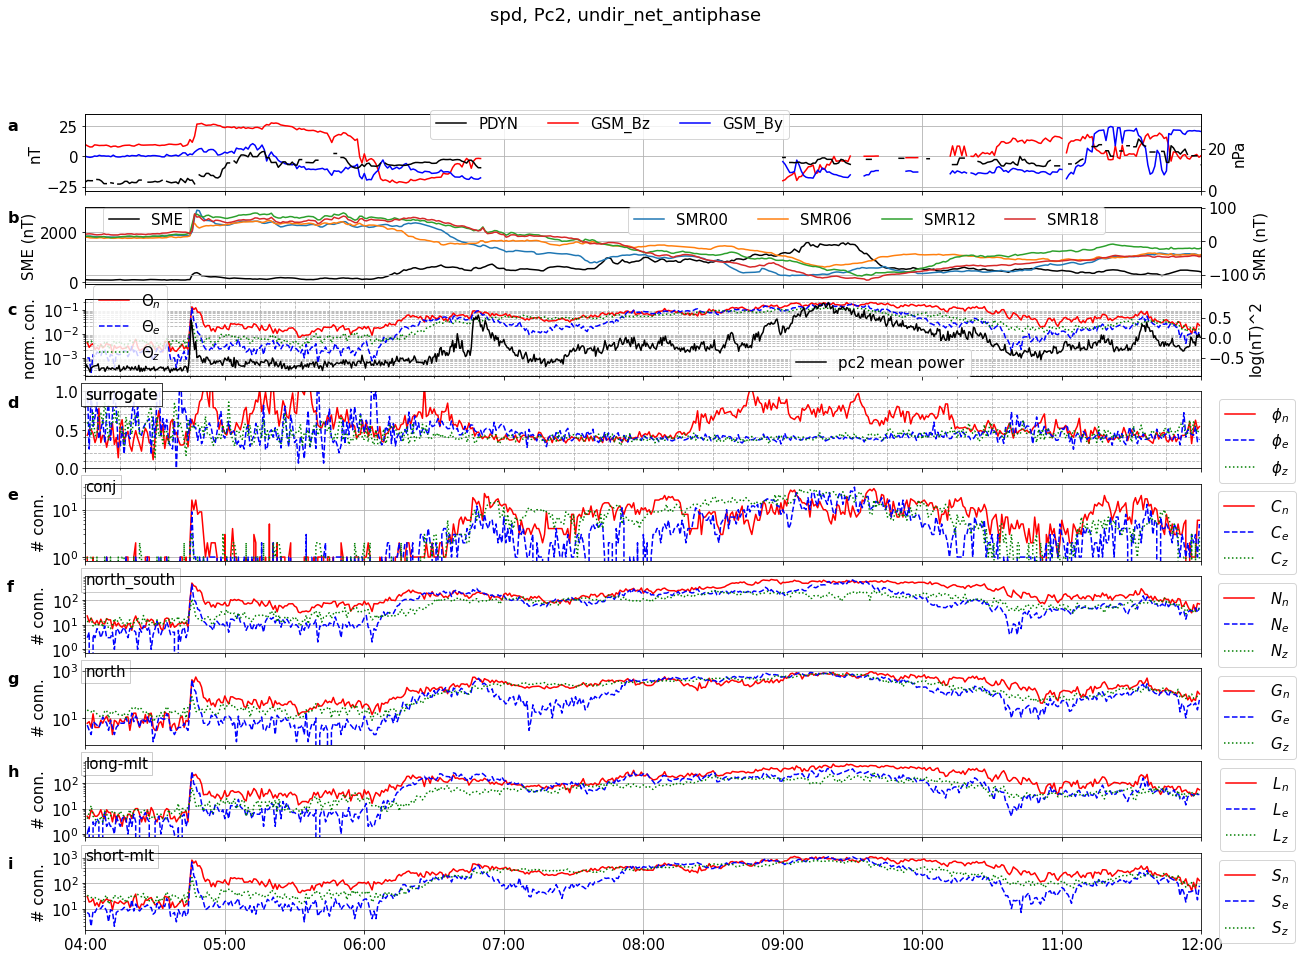

In [211]:
net_param_labels = ['conj_div_north_south', 'north_south_div_north', 'long-mlt_div_short-mlt']

# 'north_south' in both top and bottom, so for bottom 'conj_div_north_south' not needed
# for all paramters in top and for the last two in bottom
# top includes all the network parmaters

for net in net_labs[1:]:
        plot_edge_num_all_net_params(net, net_dict,
            net_param_labels, indices_fname)

In [234]:
def plot_edge_num_all_net_params_ratios(net_label:str, net_dict:dict, net_param_labels:str, indices_fname:str, conn_thresh:int):
    plt.rcParams.update({'font.size': 15})
    num_plots = 4 + len(net_param_labels) + 3
    fig, ax = plt.subplots(num_plots, figsize=(20, 15))
    fig.suptitle(f'spd, Pc2, {net_label}')
    indices = pd.read_csv(indices_fname)
    index_date = indices['Date_UTC']
    axsmer = pd.to_datetime(index_date)
    datemin = datetime.strptime(pn.dt_start, '%Y-%m-%d %H:%M:%S')
    datemax = datetime.strptime(pn.dt_end, '%Y-%m-%d %H:%M:%S')
    formatter = mdates.DateFormatter("%H:%M")

    for ind, lab in enumerate(['GSM_Bz','GSM_By','PDYN']):
        c = ['red','blue','black','green']
        if ind == 2:
            ax2 = ax[0].twinx()
            ax2.set_ylabel('nPa')
            # get rid of peaks
            y = np.where( indices[lab] == np.max(indices[lab]) , np.nan , indices[lab])
            ax2.plot(axsmer, y, label=lab, color = c[ind])
            ax2.set_xlim(datemin,datemax)
        else:
            y = np.where( indices[lab] == np.max(indices[lab]) , np.nan , indices[lab])
            ax[0].plot(axsmer, y, label=lab, color = c[ind])

    ax[0].xaxis.set_major_formatter(formatter)
    ax[0].set_ylabel('nT')
    ax[0].set_xlim(datemin,datemax)
    h1, l1 = ax2.get_legend_handles_labels()
    h2, l2 = ax[0].get_legend_handles_labels()
    ax2.legend(h1+h2, l1+l2,bbox_to_anchor=[0.47, 1.15],ncol=4,loc='upper center')
    ax[0].grid()
    ax[0].set_xticklabels([])
    
#     code for plotting SMR sections for entire SMR yearly dataset
    sme = indices['SME']
    ax[1].plot(axsmer,sme, color='black', label = 'SME')
    ax[1].set_ylabel('SME (nT)')
    ax[1].grid()
#   turn off labels for x axis while preserving ticks
    ax[1].set_xticklabels([])                           
    ax[1].set_xlim(datemin,datemax)
    ax[1].xaxis.set_major_formatter(formatter)
    ax[1].set_xlim(datemin,datemax)
    ax3 = ax[1].twinx()
    indices['Date_UTC'] = pd.to_datetime(indices['Date_UTC']) 
    for i in ['SMR00','SMR06','SMR12','SMR18' ]:
        x = axsmer[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)]
        y = indices[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)][i]
        ax3.plot(x , y, label= i)
    ax3.xaxis.set_major_formatter(formatter)
    ax[1].legend(bbox_to_anchor=[0.1,1.1])
    ax3.legend(bbox_to_anchor=[0.7, 1.1],ncol=4,loc='upper center')
    ax3.set_ylabel('SMR (nT)')
    ax3.grid()
    ax3.set_xlim(datemin,datemax)
    ax3.set_xticklabels([])
  
    
    c = ['r','b','g']
    ls = ['-','--',':']
    min_conn = conn_thresh
    min_conn_bool_dict = {}
    for c_ind, comp in enumerate(['n','e','z']):
        net_df = all_con_dict[0][comp][net_label]
        num_stations = pn.n
        min_conn_bool_dict[comp] = {}
        min_conn_bool_dict[comp] = net_df.values > min_conn
        max_conn = int(num_stations*(num_stations-1)/2)
        vals = net_df.values/max_conn
        t = pd.to_datetime(net_df.index)
        ax[2].plot(t, vals, color=c[c_ind], ls = ls[c_ind], label = f'$\Theta_{{{comp}}}$')
        ax[2].set_xlim(datemin,datemax)
        ax[2].grid(b=True, which='minor', linestyle='--')
        ax[2].set_yscale('log')
        ax[2].set_ylabel('norm. con.')
        ax[2].minorticks_on()
    ax[2].legend(loc='lower left', ncol=1)
    ax4 = ax[2].twinx()
    pc_power, power_times = pn.ulf_power(0)
    ax4.plot(power_times, pc_power['mean_pc_power'], color = 'black',label= f'pc{2} mean power')
    ax4.xaxis.set_major_formatter(formatter)
    ax4.set_xlim(datemin,datemax)
    ax4.set_ylabel('log(nT)^2')
    ax4.set_xticklabels([])
    ax4.legend(bbox_to_anchor=[0.8, 0.45])
    

    for c_ind, comp in enumerate(['n','e','z']):
        net_df = all_con_dict[0][comp][net_label]
        net_surr_df = all_surr_con_dict[0][comp][net_label]
        surr_ratio = []
        for i in net_df.index:
            if i not in net_surr_df.index:
                surr_ratio.append(0)
            else:
                v1 = net_df.loc[str(i)]['total']
                v2 = net_surr_df.loc[str(i)]['total']
                surr_ratio.append(v2/v1)
                
        plt.text(0, 0.9,f'surrogate',transform=ax[3].transAxes, bbox = dict(facecolor = 'white', alpha = 0.5))
        t1 = pd.to_datetime(net_df.index)
        ax[3].plot(t1, surr_ratio, color=c[c_ind], ls = ls[c_ind], label = f' $\phi_{{{comp}}}$')
        ax[3].set_xlim(datemin,datemax)
    ax[3].grid(b=True, which='minor', linestyle='--')
    ax[3].legend(loc='upper center',ncol=1, bbox_to_anchor=[1.05, 1])
    ax[3].minorticks_on()
    ax[3].set_xticklabels([]) 
    ax[3].set_ylim(0,1) 


#     code for plotting networks
    step = [0,1,2]
    for ind, net_param in enumerate(net_param_labels):
        print(net_param)
        for ind0, quant in enumerate(['ratio', 'ratio_rev']):
            print(quant)
            lab = net_param.split('_div_')
            if ratio =='ratio':
                lab = net_param
            else:
                lab = f'{lab[1]}_div_{lab[0]}'
            plot_num = ind0 + i+ 4 + step[ind]
            print(plot_num)
            plt.text(0, 0.9,f'{lab}',transform=ax[plot_num].transAxes, bbox = dict(facecolor = 'white', alpha = 0.2))
                
            for c_ind, comp in enumerate(['n','e','z']):
                lab_arr = label_funct(comp, quant)
                if quant=='ratio_rev':
                    a = net_dict[net_label][net_param][comp]['bottom'].values
                    b = net_dict[net_label][net_param][comp]['top'].values
                    a, b = np.squeeze(a), np.squeeze(b)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        net_val = np.where(b==0, 0, a/b)
                    print('hey')
                elif quant == 'ratio':
                    net_val = net_dict[net_label][net_param][comp][quant]
    #               mask values with connections lower than lower lim
                net_val = np.squeeze(net_val) * np.squeeze(min_conn_bool_dict[comp])
                ax[plot_num].plot(t ,net_val, color=c[c_ind], ls = ls[c_ind], label = f' {lab_arr[ind]}')
            ax[plot_num].set_xlim(datemin,datemax)
            ax[plot_num].grid()
            ax[plot_num].legend(loc='upper center',ncol=1, bbox_to_anchor=[1.05, 1])
            ax[plot_num].set_yscale('log')
            if plot_num<num_plots-1:
                ax[plot_num].set_xticklabels([])
            else:
                ax[plot_num].xaxis.set_major_formatter(formatter)
    
    for n in range(num_plots):
        ax[n].text(-0.07, 0.8, string.ascii_lowercase[n], transform=ax[n].transAxes, 
                size=16, weight='bold')
    
    plt.subplots_adjust(wspace=0, hspace=0.2)
#     plt.savefig(f'plots/{year}_nets/{net_label}_all_comps_ratio_rev_net_params_{conn_thresh}_.png', facecolor='w')
#     plt.show()

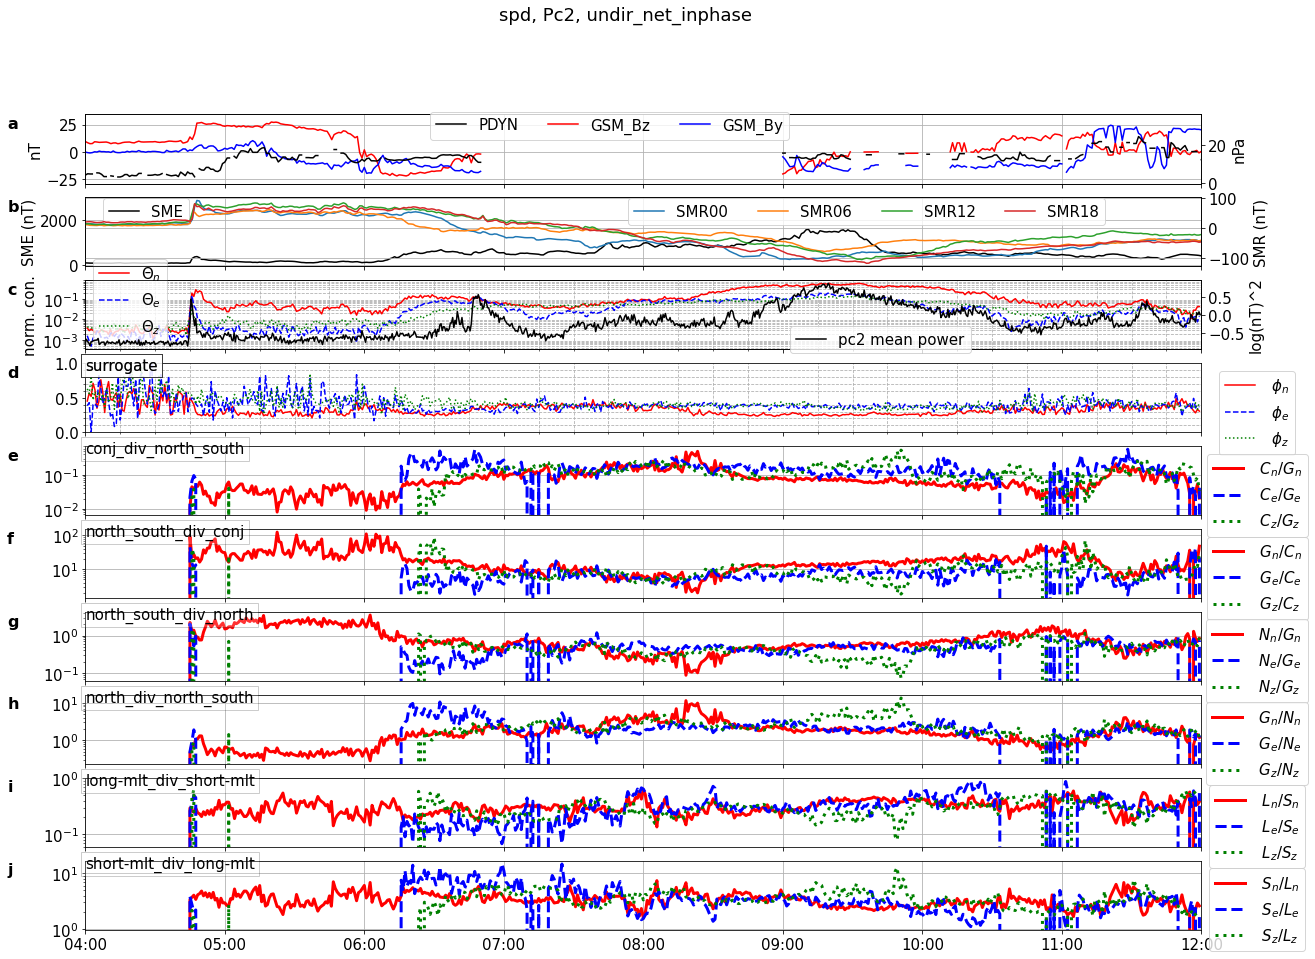

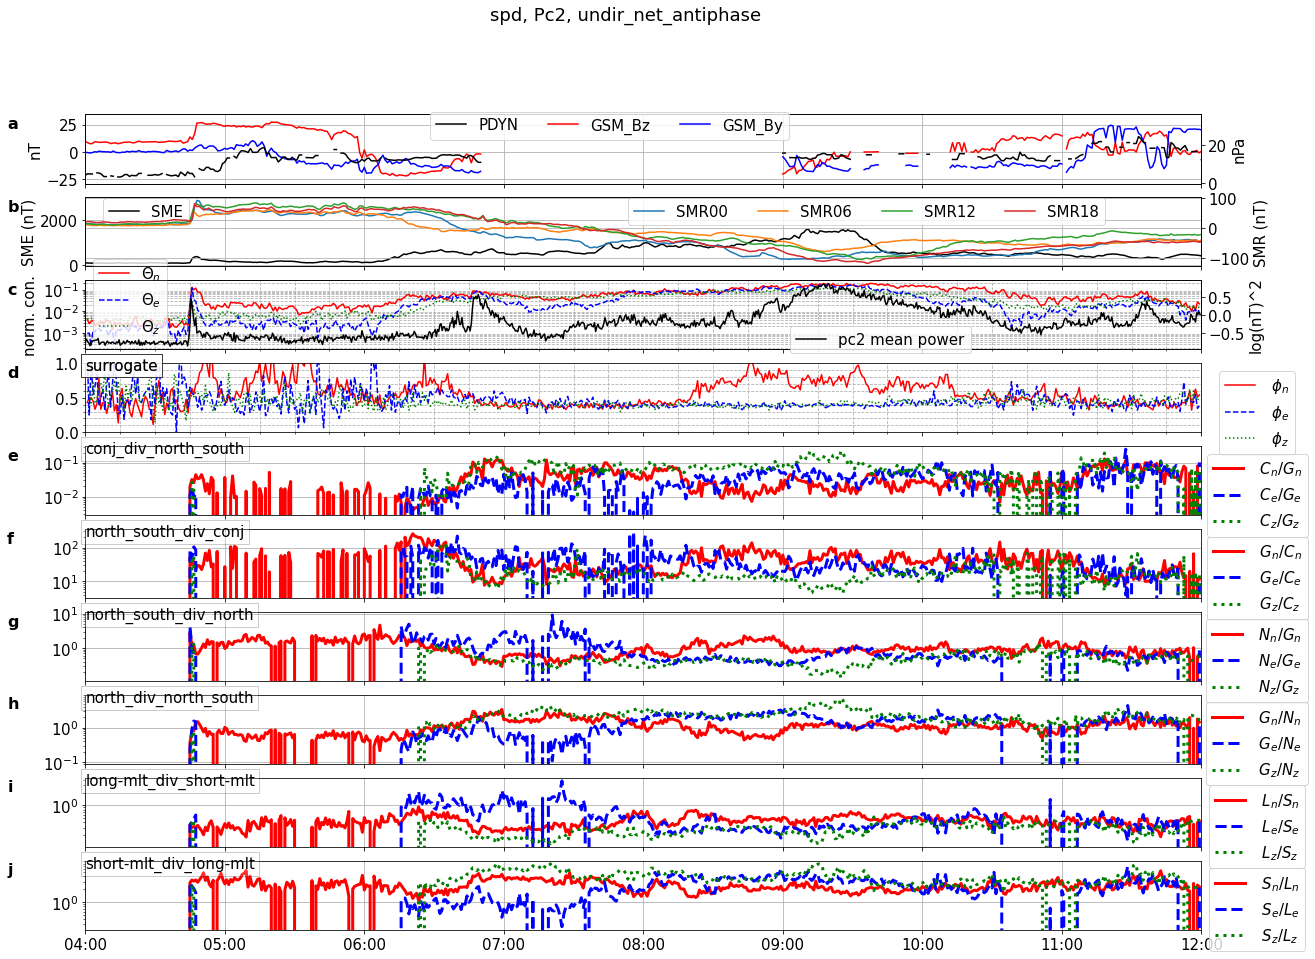

In [235]:
for net in net_labs[1:]:
        plot_edge_num_all_net_params_ratios(net, net_dict,
            net_param_labels, indices_fname, conn_thresh=100)

In [ ]:
def plot_edge_num_all_net_params_ratios(net_label:str, net_dict:dict, net_param_labels:str, indices_fname:str, conn_thresh:int):
    plt.rcParams.update({'font.size': 15})
    num_plots = 4 + len(net_param_labels) + 3
    fig, ax = plt.subplots(num_plots, figsize=(20, 15))
    fig.suptitle(f'spd, Pc2, {net_label}')
    indices = pd.read_csv(indices_fname)
    index_date = indices['Date_UTC']
    axsmer = pd.to_datetime(index_date)
    datemin = datetime.strptime(pn.dt_start, '%Y-%m-%d %H:%M:%S')
    datemax = datetime.strptime(pn.dt_end, '%Y-%m-%d %H:%M:%S')
    formatter = mdates.DateFormatter("%H:%M")

    for ind, lab in enumerate(['GSM_Bz','GSM_By','PDYN']):
        c = ['red','blue','black','green']
        if ind == 2:
            ax2 = ax[0].twinx()
            ax2.set_ylabel('nPa')
            # get rid of peaks
            y = np.where( indices[lab] == np.max(indices[lab]) , np.nan , indices[lab])
            ax2.plot(axsmer, y, label=lab, color = c[ind])
            ax2.set_xlim(datemin,datemax)
        else:
            y = np.where( indices[lab] == np.max(indices[lab]) , np.nan , indices[lab])
            ax[0].plot(axsmer, y, label=lab, color = c[ind])

    ax[0].xaxis.set_major_formatter(formatter)
    ax[0].set_ylabel('nT')
    ax[0].set_xlim(datemin,datemax)
    h1, l1 = ax2.get_legend_handles_labels()
    h2, l2 = ax[0].get_legend_handles_labels()
    ax2.legend(h1+h2, l1+l2,bbox_to_anchor=[0.47, 1.15],ncol=4,loc='upper center')
    ax[0].grid()
    ax[0].set_xticklabels([])
    
#     code for plotting SMR sections for entire SMR yearly dataset
    sme = indices['SME']
    ax[1].plot(axsmer,sme, color='black', label = 'SME')
    ax[1].set_ylabel('SME (nT)')
    ax[1].grid()
#   turn off labels for x axis while preserving ticks
    ax[1].set_xticklabels([])                           
    ax[1].set_xlim(datemin,datemax)
    ax[1].xaxis.set_major_formatter(formatter)
    ax[1].set_xlim(datemin,datemax)
    ax3 = ax[1].twinx()
    indices['Date_UTC'] = pd.to_datetime(indices['Date_UTC']) 
    for i in ['SMR00','SMR06','SMR12','SMR18' ]:
        x = axsmer[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)]
        y = indices[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)][i]
        ax3.plot(x , y, label= i)
    ax3.xaxis.set_major_formatter(formatter)
    ax[1].legend(bbox_to_anchor=[0.1,1.1])
    ax3.legend(bbox_to_anchor=[0.7, 1.1],ncol=4,loc='upper center')
    ax3.set_ylabel('SMR (nT)')
    ax3.grid()
    ax3.set_xlim(datemin,datemax)
    ax3.set_xticklabels([])
  
    
    c = ['r','b','g']
    ls = ['-','--',':']
    min_conn = conn_thresh
    min_conn_bool_dict = {}
    for c_ind, comp in enumerate(['n','e','z']):
        net_df = all_con_dict[0][comp][net_label]
        num_stations = pn.n
        min_conn_bool_dict[comp] = {}
        min_conn_bool_dict[comp] = net_df.values > min_conn
        max_conn = int(num_stations*(num_stations-1)/2)
        vals = net_df.values/max_conn
        t = pd.to_datetime(net_df.index)
        ax[2].plot(t, vals, color=c[c_ind], ls = ls[c_ind], label = f'$\Theta_{{{comp}}}$')
        ax[2].set_xlim(datemin,datemax)
        ax[2].grid(b=True, which='minor', linestyle='--')
        ax[2].set_yscale('log')
        ax[2].set_ylabel('norm. con.')
        ax[2].minorticks_on()
    ax[2].legend(loc='lower left', ncol=1)
    ax4 = ax[2].twinx()
    pc_power, power_times = pn.ulf_power(0)
    ax4.plot(power_times, pc_power['mean_pc_power'], color = 'black',label= f'pc{2} mean power')
    ax4.xaxis.set_major_formatter(formatter)
    ax4.set_xlim(datemin,datemax)
    ax4.set_ylabel('log(nT)^2')
    ax4.set_xticklabels([])
    ax4.legend(bbox_to_anchor=[0.8, 0.45])
    

    for c_ind, comp in enumerate(['n','e','z']):
        net_df = all_con_dict[0][comp][net_label]
        net_surr_df = all_surr_con_dict[0][comp][net_label]
        surr_ratio = []
        for i in net_df.index:
            if i not in net_surr_df.index:
                surr_ratio.append(0)
            else:
                v1 = net_df.loc[str(i)]['total']
                v2 = net_surr_df.loc[str(i)]['total']
                surr_ratio.append(v2/v1)
                
        plt.text(0, 0.9,f'surrogate',transform=ax[3].transAxes, bbox = dict(facecolor = 'white', alpha = 0.5))
        t1 = pd.to_datetime(net_df.index)
        ax[3].plot(t1, surr_ratio, color=c[c_ind], ls = ls[c_ind], label = f' $\phi_{{{comp}}}$')
        ax[3].set_xlim(datemin,datemax)
    ax[3].grid(b=True, which='minor', linestyle='--')
    ax[3].legend(loc='upper center',ncol=1, bbox_to_anchor=[1.05, 1])
    ax[3].minorticks_on()
    ax[3].set_xticklabels([]) 
    ax[3].set_ylim(0,1) 


#     code for plotting networks
    step = [0,2,4]
    for ind, net_param in enumerate(net_param_labels):
        for ind0, quant in enumerate(['ratio', 'ratio_rev']):
            lab = net_param.split('_div_')
            if quant =='ratio':
                lab = net_param
            elif quant =='ratio_rev':
                lab = f'{lab[1]}_div_{lab[0]}'
            plot_num = ind0 + 4 + step[ind]
            plt.text(0, 0.9,f'{lab}',transform=ax[plot_num].transAxes, bbox = dict(facecolor = 'white', alpha = 0.2))
                
            for c_ind, comp in enumerate(['n','e','z']):
                lab_arr = label_funct(comp, quant)
                if quant=='ratio_rev':
                    a = net_dict[net_label][net_param][comp]['bottom'].values
                    b = net_dict[net_label][net_param][comp]['top'].values
                    a, b = np.squeeze(a), np.squeeze(b)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        net_val = np.where(b==0, 0, a/b)
                    net_val = np.squeeze(net_val) * np.squeeze(min_conn_bool_dict[comp])
                    t = pd.to_datetime(net_dict[net_label][net_param][comp]['ratio'].index)
                    ax[plot_num].plot(t ,net_val, color=c[c_ind], ls = ls[c_ind], label = f' {lab_arr[ind]}', lw=3)
                elif quant == 'ratio':
                    net_val = net_dict[net_label][net_param][comp][quant]
    #               mask values with connections lower than lower lim
                    net_val = np.squeeze(net_val) * np.squeeze(min_conn_bool_dict[comp])
                    t = pd.to_datetime(net_dict[net_label][net_param][comp]['ratio'].index)
                    ax[plot_num].plot(t ,net_val, color=c[c_ind], ls = ls[c_ind], label = f' {lab_arr[ind]}', lw=3)
            ax[plot_num].set_xlim(datemin,datemax)
            ax[plot_num].grid()
            ax[plot_num].legend(loc='upper center',ncol=1, bbox_to_anchor=[1.05, 1])
            ax[plot_num].set_yscale('log')
            if plot_num<num_plots-1:
                ax[plot_num].set_xticklabels([])
            else:
                ax[plot_num].xaxis.set_major_formatter(formatter)
    
    for n in range(num_plots):
        ax[n].text(-0.07, 0.8, string.ascii_lowercase[n], transform=ax[n].transAxes, 
                size=16, weight='bold')
    
    plt.subplots_adjust(wspace=0, hspace=0.2)
#     plt.savefig(f'plots/{year}_nets/{net_label}_all_comps_ratio_rev_net_params_{conn_thresh}_.png', facecolor='w')
#     plt.show()